In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model

import keras
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, BatchNormalization, LSTM, concatenate
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras import optimizers
from keras.utils import to_categorical
import seaborn as sns

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = np.dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + './data/UCI_HAR_Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + './data/UCI_HAR_Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy


In [3]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [4]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	plt.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = plt.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		plt.hist(longX[:, i], bins=100)
	plt.show()

(470528, 9)


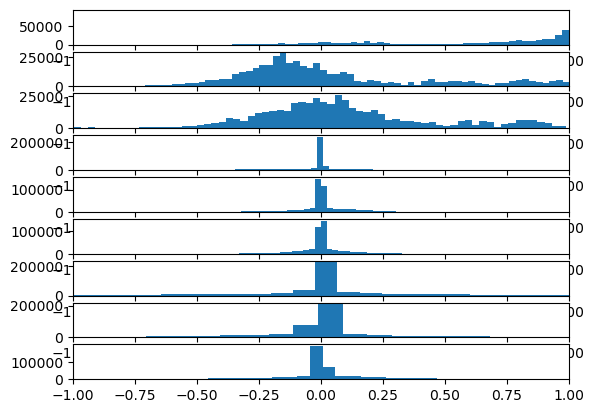

In [5]:
# plot distributions
plot_distributions(trainX)

### CNN model

Model design:

We will define the model as having two 1D CNN layers (each with 64 filters of kernel size 4), followed by a dropout layer to avoid overfiting for training set, then a pooling layer before flattening and connecting to the fully connected layer. At last we have the final softmax layer which represent the 6 classes similar to the LSTM model.

In [6]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 125, 64)           2368      
                                                                 
 conv1d_1 (Conv1D)           (None, 122, 64)           16448     
                                                                 
 dropout (Dropout)           (None, 122, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 61, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3904)              0         
                                       

Compile the model with [categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) loss function and [ADAM optimizer](https://keras.io/api/optimizers/).

In [7]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train the model

In [8]:
# fit network
batch_size = 64
validation_split = 0.2
train_epochs = 20
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/20
92/92 [==============================] - 3s 19ms/step - loss: 0.4632 - accuracy: 0.8133 - val_loss: 0.3954 - val_accuracy: 0.9021
Epoch 2/20
92/92 [==============================] - 2s 17ms/step - loss: 0.1439 - accuracy: 0.9461 - val_loss: 0.3537 - val_accuracy: 0.8967
Epoch 3/20
92/92 [==============================] - 2s 18ms/step - loss: 0.1131 - accuracy: 0.9539 - val_loss: 0.3383 - val_accuracy: 0.9177
Epoch 4/20
92/92 [==============================] - 2s 19ms/step - loss: 0.1053 - accuracy: 0.9526 - val_loss: 0.3504 - val_accuracy: 0.8967
Epoch 5/20
92/92 [==============================] - 2s 18ms/step - loss: 0.1008 - accuracy: 0.9554 - val_loss: 0.3766 - val_accuracy: 0.9157
Epoch 6/20
92/92 [==============================] - 2s 17ms/step - loss: 0.0831 - accuracy: 0.9623 - val_loss: 0.4106 - val_accuracy: 0.9082
Epoch 7/20
92/92 [==============================] - 2s 17ms/step - loss: 0.0852 - accuracy: 0.9592 - val_loss: 0.3708 - val_accuracy: 0.9130
Epoch 8/20
92

Visualize the training process (loss) w.r.t train set and the validation set

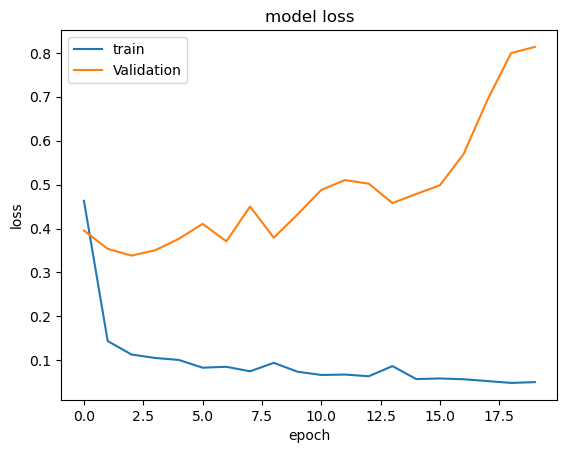

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [10]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(testX)

Accuracy of the CNN model 0.9100780487060547
93/93 [==============================] - 0s 3ms/step


In [11]:
from sklearn.metrics import confusion_matrix, classification_report

In [12]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[446  22  28   0   0   0]
 [  3 434  34   0   0   0]
 [  0   2 418   0   0   0]
 [  1  21   0 419  44   6]
 [  3   2   0  83 444   0]
 [  0  15   1   0   0 521]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.98      0.90      0.94       496
           2       0.88      0.92      0.90       471
           3       0.87      1.00      0.93       420
           4       0.83      0.85      0.84       491
           5       0.91      0.83      0.87       532
           6       0.99      0.97      0.98       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



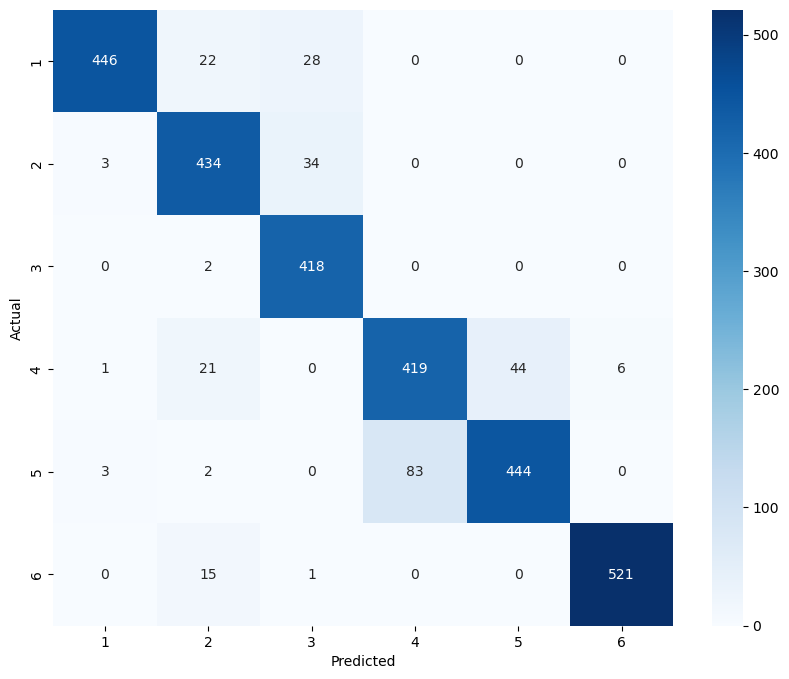

In [13]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

Predicting for a single sample

In [14]:
# we will select the first sample from the test set
sample = testX[0]
sample.shape

(128, 9)

In [15]:
# predict the results using the model, we need to input in the form of (numberOfSamples,featureLength,numberOfFeatures)
predictionForSample = model.predict(sample.reshape(1,sample.shape[0],sample.shape[1]))

1/1 [==============================] - 0s 19ms/step


In [16]:
# get the class of the sample
samplePredictedClass = np.argmax(predictionForSample, axis=1)
sampleActualClass = np.argmax(testy, axis=1)
print("Actual class: ",sampleActualClass[0])
print("Predicted class: ",samplePredictedClass[0])

Actual class:  4
Predicted class:  4
